In [165]:
import os

import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as DataClass
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F
from pydicom import Dataset
from PIL import Image
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix


In [166]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


In [167]:
class BCDRDataset(Dataset):
    def __init__(self, root_dir, train=True, data_augmentation=True):
        self.image_paths = []
        self.labels = []
        
        base_transform = [
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5186, 0.5187, 0.5185], std=[0.1957, 0.1957, 0.1957])
        ]

        augmentation_transform = [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15)
        ]

        if train and data_augmentation:
            self.transform = transforms.Compose(augmentation_transform + base_transform)
        else:
            self.transform = transforms.Compose(base_transform)

        for label in ['0', '1']:
            folder_path = os.path.join(root_dir, label)
            images = sorted(os.listdir(folder_path)) 
            self.image_paths.extend([os.path.join(folder_path, img_name) for img_name in images])
            self.labels.extend([int(label)] * len(images))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  
        return image, label

In [168]:
train_dir = '/home/eflammere/BreastCancerQuanvolution/Datasets/BCDR/png/train/'
test_dir = '/home/eflammere/BreastCancerQuanvolution/Datasets/BCDR/png/test'

train_dataset = BCDRDataset(root_dir=train_dir, train=True)
test_dataset = BCDRDataset(root_dir=test_dir, train=False)

batch_size = 32

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [169]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    #nn.ReLU(),
    #nn.Dropout(0.4),
    #nn.Linear(64, 1),
    nn.Sigmoid()
)
print(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss().to(device)
epochs = 500

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [170]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
val_precisions, val_recalls, val_f1_scores, val_aucs = [], [], [], []

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")

    # Treinamento
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for inputs, labels in dataloader_train:
        inputs, labels = inputs.to(device), labels.view(-1).to(device).float()
        
        # Ajuste para 3 canais, se necessário
        if inputs.shape[1] != 3:
            inputs = inputs.repeat(1, 3, 1, 1)  

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (outputs.round() == labels).float().mean().item()

    train_losses.append(total_loss / len(dataloader_train))
    train_accuracies.append(total_acc / len(dataloader_train))

    print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}")

    # Salvar modelo de forma segura
    with torch.no_grad():
        torch.save(model.state_dict(), "last_model.pth")

print("Saved 'last_model.pth'")


Epoch: 1/500
Train Loss: 0.4948 | Train Acc: 0.7359
Epoch: 2/500
Train Loss: 0.3500 | Train Acc: 0.8200
Epoch: 3/500
Train Loss: 0.3196 | Train Acc: 0.8790
Epoch: 4/500
Train Loss: 0.2594 | Train Acc: 0.8836
Epoch: 5/500
Train Loss: 0.2261 | Train Acc: 0.9280
Epoch: 6/500
Train Loss: 0.2060 | Train Acc: 0.9014
Epoch: 7/500
Train Loss: 0.1981 | Train Acc: 0.9369
Epoch: 8/500
Train Loss: 0.1777 | Train Acc: 0.9281
Epoch: 9/500
Train Loss: 0.3125 | Train Acc: 0.9104
Epoch: 10/500
Train Loss: 0.2213 | Train Acc: 0.8969
Epoch: 11/500
Train Loss: 0.1713 | Train Acc: 0.9280
Epoch: 12/500
Train Loss: 0.1892 | Train Acc: 0.9284
Epoch: 13/500
Train Loss: 0.1101 | Train Acc: 0.9641
Epoch: 14/500
Train Loss: 0.1390 | Train Acc: 0.9369
Epoch: 15/500
Train Loss: 0.1469 | Train Acc: 0.9240
Epoch: 16/500
Train Loss: 0.1006 | Train Acc: 0.9640
Epoch: 17/500
Train Loss: 0.1376 | Train Acc: 0.9507
Epoch: 18/500
Train Loss: 0.0721 | Train Acc: 0.9688
Epoch: 19/500
Train Loss: 0.0994 | Train Acc: 0.9594
Ep

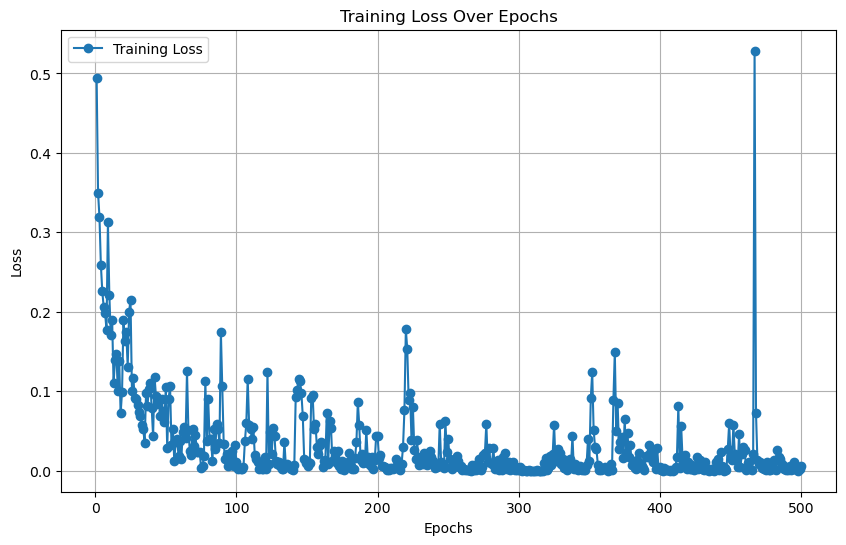

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [172]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

test_loss = 0.0
test_labels, test_predictions, test_probs = [], [], []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs = inputs.to(device)

        # Ensure correct input shape
        if inputs.shape[1] == 1:
            inputs = inputs.repeat(1, 3, 1, 1)

        labels = labels.view(-1).to(device).float()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        test_labels.extend(labels.cpu().numpy())

        # For binary classification: use sigmoid, else softmax
        if len(outputs.shape) == 1:  
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
        else:
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

        test_predictions.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
test_probs = np.array(test_probs)

# Compute metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average="weighted", zero_division=0)
test_recall = recall_score(test_labels, test_predictions, average="weighted", zero_division=0)
test_f1 = f1_score(test_labels, test_predictions, average="weighted", zero_division=0)

# AUC calculation fix
if test_probs.ndim == 1:
    test_auc = roc_auc_score(test_labels, test_probs)
else:
    test_auc = roc_auc_score(test_labels, test_probs[:, 1])  # Class 1 probabilities

# Print results
print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(dataloader_test):.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")
print(f"Test F1 Score: {test_f1 * 100:.2f}%")
print(f"Test AUC: {test_auc * 100:.2f}%")



Final Test Evaluation:
Test Loss: 1.9840
Test Accuracy: 75.71%
Test Precision: 86.61%
Test Recall: 75.71%
Test F1 Score: 77.84%
Test AUC: 92.91%


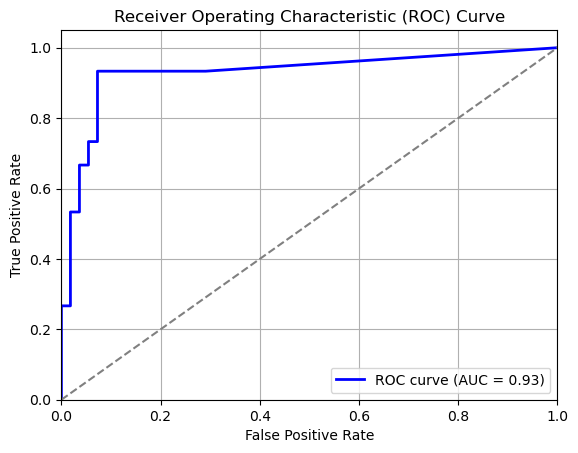

ROC curve data exported to 'roc_curve_data_BreastMNIST.csv'


In [173]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    test_labels, test_probs
)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

dataset_name = "BreastMNIST"
roc_data = pd.DataFrame({
    'Dataset': [dataset_name] * len(false_positive_rate),
    'False Positive Rate': false_positive_rate,
    'True Positive Rate': true_positive_rate,
    'Thresholds': thresholds
})
roc_data.to_csv(f'/home/eflammere/BreastCancerQuanvolution/Classic/checkpoints/BCDR/ResNet18/224x224/roc_curve_data_{dataset_name}.csv', index=False)

print(f"ROC curve data exported to 'roc_curve_data_{dataset_name}.csv'")

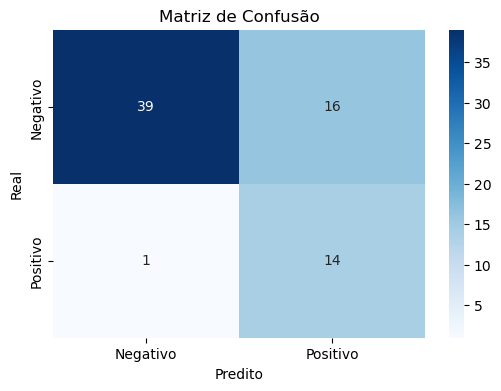

In [174]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()